# Titanic dataset

Exploring how to set up pipelines for streamlining and automating the machine learning workflow. Combines multiple data preprocessing steps and estimator into a single object. Notebook inspired by https://www.youtube.com/@NeuralNine

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os

In [202]:
path = str(os.getcwd())
if (path.split('\\')[-1]) != 'Titanic': 
    os.chdir('{}\Titanic'.format(os.getcwd()))
    print('Changed', os.getcwd())
else:
    print(os.getcwd())

C:\Users\tnf\Documents\KodeProsjekter\2023\Kaggle\Titanic


In [203]:
data = pd.read_csv('dataset/train.csv')
data.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


Exploring the dataset. Name and ticket maybe not relevant. Feature 'SibSp' telles number of siblings/spouses on Titanic. Parch number of parents/children.  

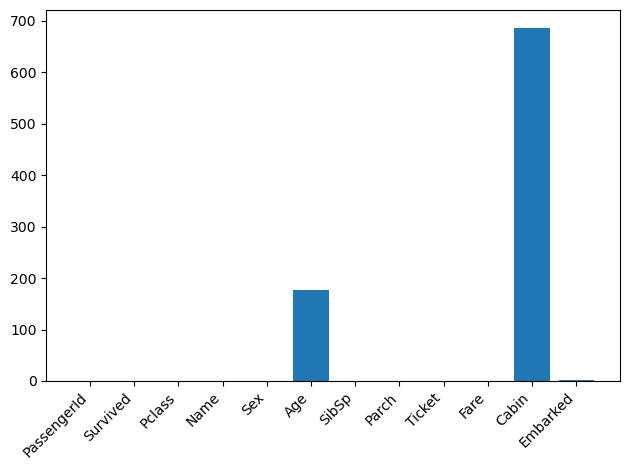

In [204]:
data.shape # (891, 12)

lenX = len(data.columns)
nullList = []
for col in data.columns:
    nullList.append(data[col].isnull().sum()) # sum() counts all the true values in pd.series()

allList = []
for col in data.columns: 
    allList.append(data[col].count())
    
plt.bar(data.columns, nullList)
plt.xticks(rotation=45, ha='right', label="Null values")
plt.tight_layout()
plt.show()


Plot of null values in the dataset. Cabin 

In [205]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


Example: 25% is younger than 20.125 y/o while still younger than 75% of the sample population. (25% describe number which is bigger than 25% of the samples, while smaller than 75%) 

C:\Users\tnf\AppData\Local\Temp\ipykernel_10788\2318045746.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="YlGnBu")


<Axes: >

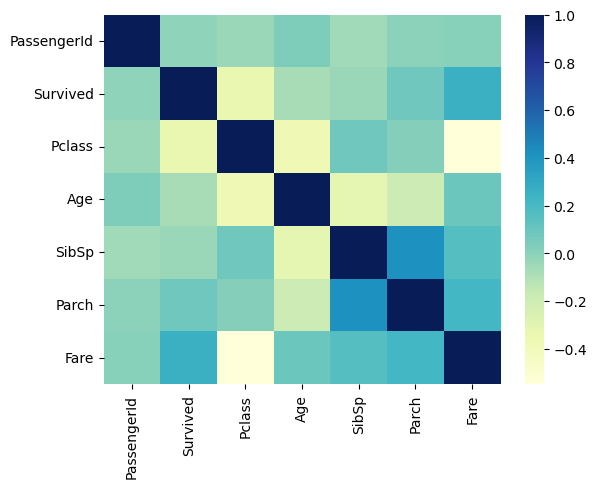

In [206]:
sns.heatmap(data.corr(), cmap="YlGnBu")


Intrested in what's correlated to the survived feature. The fare class is actually higly negatively corr with survivial. Makes sence because survival has class 0 or 1, while Pclass 1,2,3 (1 is the best). (as Pclasses moves from 1 to 3, there is a negative trend in survival..)  

In [207]:
from sklearn.model_selection import StratifiedShuffleSplit

In [208]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
split_data = split.split(data, data[["Survived", "Pclass", "Sex"]])

for train_indices, test_indices in split_data:
    strat_train_set = data.loc[train_indices]
    strat_test_set = data.loc[test_indices]


Splitting train and test dataset with StratifiedShuffleSplit. Picks important features and tries having same distribution in both datasets. 

<Axes: >

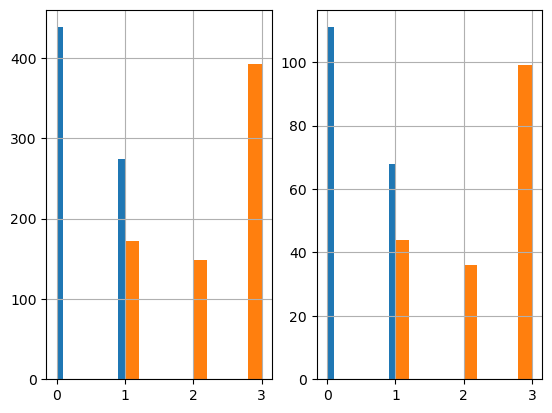

In [209]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

Distribution follow each other. 

In [210]:
strat_train_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 138 to 846
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          570 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


Age data is missing for many of the samples. Could drop or estimators. 

In [211]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer # Strategy for filling in missing values

class AgeImputer(BaseEstimator, TransformerMixin): 
    """ Imputer for Age feature """
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        imputer = SimpleImputer(strategy="mean") # using mean strategy
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X
    

In [212]:
# testing oneHot

from sklearn.preprocessing import OneHotEncoder
da = ['A', 'B', 'C', 'A', 'C', 'D']
da = np.array(da).reshape(-1, 1)
encoder = OneHotEncoder()
a = encoder.fit_transform(da)
print(a)
print(a.toarray())
print(len(a.toarray()))


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 2)	1.0
  (5, 3)	1.0
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
6


In [213]:
from sklearn.preprocessing import OneHotEncoder


class FeatureEncoder(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray() # creates a one hot encoded matrix
        print(len(matrix))
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i] # assigns the rows with the one hot encoded rows
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()  
        column_names = ["Females", "Male"]
                       
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i] # assigns the rows with the one hot encoded rows
        return X

# a = FeatureEncoder()
# a.transform(data)
    

In [214]:
class FeatureDropper(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
    


In [215]:
from sklearn.pipeline import Pipeline 

# Defining the pipeline which the dataset will "flow" thorugh.
pipeline = Pipeline([('ageimputer', AgeImputer()), 
                     ('featureencoder', FeatureEncoder()), 
                     ('featuredropper', FeatureDropper())])


In [216]:
strat_train_set = pipeline.fit_transform(strat_train_set)

712


Onehot encoded feauters in seperate coloumns

In [217]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 138 to 846
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Females      712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [218]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()
X_data
# changing the distribution standard deviation to equal one.  

array([[-1.20549947,  0.82789342, -1.03987513, ...,  0.625     ,
        -0.73561236,  0.73561236],
       [ 0.48839628,  0.82789342, -1.03987513, ...,  0.625     ,
        -0.73561236,  0.73561236],
       [-0.58388635, -1.56828591,  0.        , ...,  0.625     ,
        -0.73561236,  0.73561236],
       ...,
       [ 1.47132202, -0.37019624, -2.18899456, ..., -1.6       ,
        -0.73561236,  0.73561236],
       [ 0.73704152,  0.82789342,  0.87532392, ...,  0.625     ,
         1.35941164, -1.35941164],
       [ 1.54513858,  0.82789342,  0.        , ...,  0.625     ,
        -0.73561236,  0.73561236]])

In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

Ensemble combines multiple models, thus a collection of model is used to make predictions rather than an individual model. Ensemble uses two types of methods, 

- Bagging (Bootstrap Aggregation): Creates different training subset from sample training data with replacement (row sampling with replacement is called bootstrap). Final output based on majority voting (aggregation).  Example Random forrest

- Boosting: Combines multiple simple models (known as weak learners or base estimators) to generate the final output. Builds a model by using weak models in series. Example AdaBoost

Important features of random forest: Not all features are considered while making an individual tree; each tree is different. Immune to the curse of dimensinality, parallelization, stability and no train-test split. 

In [220]:
clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10], 
    "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [224]:
final_clf = grid_search.best_estimator_

In [225]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=10)

In [229]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 502 to 146
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    float64
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Fare         179 non-null    float64
 7   C            179 non-null    float64
 8   S            179 non-null    float64
 9   Q            179 non-null    float64
 10  Females      179 non-null    float64
 11  Male         179 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 18.2 KB


In [234]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

print(X_data_test.shape)
print(len(y_data_test))

(179, 11)
179


In [235]:
final_clf.score(X_data_test, y_data_test)

0.8324022346368715

In [236]:
final_data = pipeline.fit_transform(data)

X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

891


In [237]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10], 
    "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [238]:
final_clf = grid_search.best_estimator_

In [239]:
final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)